In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import networkx as nx
from pprint import pprint
import os
import json

## Dataset from Kaggle: https://www.kaggle.com/rounakbanik/the-movies-dataset

In [2]:
# Read the files
movies_metadata = pd.read_csv('movies_metadata.csv')

/Users/zipeng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Remove rows with dirty data
shitty_idx = []
for idx, row in movies_metadata.iterrows():
    if not row['id'].isdigit():
        shitty_idx.append(idx)
print(shitty_idx)
movies_metadata.drop(shitty_idx, axis=0, inplace=True)

[19730, 29503, 35587]


In [4]:
# Change the index type to int and remove duplicated
print(movies_metadata.shape)
movies_metadata['id'] = movies_metadata['id'].astype('int64')
movies_metadata.drop_duplicates(subset='id', inplace=True)
movies_metadata.set_index('id', inplace=True)
print(movies_metadata.shape)
print(movies_metadata.index)

(45463, 24)
(45433, 23)
Int64Index([   862,   8844,  15602,  31357,  11862,    949,  11860,  45325,
              9091,    710,
            ...
             84419, 390959, 289923, 222848,  30840, 439050, 111109,  67758,
            227506, 461257],
           dtype='int64', name='id', length=45433)


In [5]:
keywords = pd.read_csv('keywords.csv')
print(keywords.shape)
keywords.drop_duplicates(subset='id', inplace=True)
keywords.set_index('id', inplace=True)
print(keywords.shape)

(46419, 2)
(45432, 1)


In [6]:
credits = pd.read_csv('credits.csv')
print(credits.shape)
credits.drop_duplicates(subset='id', inplace=True)
credits.set_index('id', inplace=True)
print(credits.shape)

(45476, 3)
(45432, 2)


In [7]:
df = movies_metadata.join(keywords, how='inner').join(credits, how='inner')

In [8]:
print(movies_metadata.shape)
print(keywords.shape)
print(credits.shape)
print(df.shape)

(45433, 23)
(45432, 1)
(45432, 2)
(45432, 26)


In [9]:
df.head()

,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords,cast,crew
id,,,,,,,,,,,,,,,,,,,,,
862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
8844,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
31357,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
11862,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [10]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'keywords', 'cast', 'crew'],
      dtype='object')

In [11]:
# Clean and transform some columns that comes with an array
parse_col = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages', 
             'cast', 'crew', 'belongs_to_collection']
for column in parse_col:
    df[column] = df[column].fillna('[]').apply(literal_eval)
    df[column + '_cnt'] = df[column].map(len)
    print(column)
    print(df[column + '_cnt'].describe())
    print()

genres
count    45432.000000
mean         2.003324
std          1.130698
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: genres_cnt, dtype: float64

keywords
count    45432.000000
mean         3.446954
std          4.690083
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        149.000000
Name: keywords_cnt, dtype: float64

production_countries
count    45432.000000
mean         1.086635
std          0.763007
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         25.000000
Name: production_countries_cnt, dtype: float64

production_companies
count    45432.000000
mean         1.550977
std          1.741638
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         26.000000
Name: production_companies_cnt, dtype: float64

spoken_languages
count    45432.000000
mean         1.172434
std        

In [12]:
# A hack to get rid of the NaN, which is not compatible with JSON serializer
df['homepage'].fillna('', inplace=True)
df['tagline'].fillna('', inplace=True)

In [13]:
# Take a look at the "array-like" columns by constructing different tables from them
def inspect_entities(e_name, id_col='id', include_cols=[]):
    entity_dict = {}
    for idx, row in df.iterrows():
        # quick hack for columns that are of type dict instead of array of dict
        temp = [row[e_name]] if e_name == 'belongs_to_collection' and pd.notna(row[e_name]) else row[e_name]
        for g in temp:
            eid = g[id_col]
            if eid not in entity_dict:
                entity_dict[eid] = {'name': g['name'], 'count': 0}
                # fill in the fields to be included
                for f in include_cols:
                    if f in g:
                        entity_dict[eid][f] = g[f]
            entity_dict[eid]['count'] += 1
    entity_df = pd.DataFrame(entity_dict).transpose()
    entity_df['count'] = entity_df['count'].astype('int')
    entity_df.sort_values('count', ascending=False, inplace=True)
    return entity_df

In [14]:
genres_df = inspect_entities('genres')
genres_df

,count,name
18,20244,Drama
35,13176,Comedy
53,7619,Thriller
10749,6730,Romance
28,6592,Action
27,4671,Horror
80,4304,Crime
99,3930,Documentary
12,3490,Adventure
878,3044,Science Fiction


In [15]:
# plt.hist(genres_df['count'], bins=50)
# plt.grid(True)
# plt.show()

In [16]:
keywords_df = inspect_entities('keywords')
keywords_df

,count,name
187056,3039,woman director
10183,1914,independent film
9826,1285,murder
818,822,based on novel
4344,726,musical
572,679,sex
14819,647,violence
2483,629,nudity
9748,618,revenge
5565,613,biography


<IPython.core.display.Javascript object>


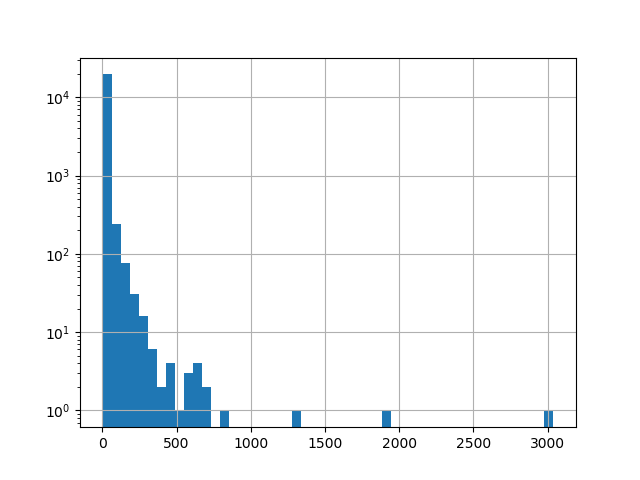

In [17]:
plt.hist(keywords_df['count'], bins=50, log=True)
plt.grid(True)
plt.show()

In [18]:
cast_df = inspect_entities('cast', include_cols=['gender', 'profile_path'])
cast_df

,count,gender,name,profile_path
121323,241,1,Bess Flowers,/akbW8jJl8GSXFpixFaobMOqvNv4.jpg
113,148,2,Christopher Lee,/aVzp6zflzedmdKPLxaPqcZ05PDK.jpg
4165,125,2,John Wayne,/iw9gHSQj1l3TQeiJb5tNK2N8k2w.jpg
2231,123,2,Samuel L. Jackson,/AvCReLikjzYEf9XjTQxbv3JWgKT.jpg
3895,110,2,Michael Caine,/vvj0JMSFpOajXCE46Hy4dyqSP2U.jpg
16927,110,2,Gérard Depardieu,/kWGuy8UI8y3uqqCVoFvBVBe8w0J.jpg
8516,109,2,John Carradine,/iv9pZ2JRddIUNe2RgYAKmUR55WO.jpg
55636,108,2,Donald Sutherland,/tPLVaPjxEscGPKS3ieByloa8Mqj.jpg
18897,108,2,Jackie Chan,/tEJazyboCJcsvxnhKH3Hf33Bmgj.jpg
15831,107,2,Frank Welker,/b3gImArbw13mMKJIe9leFc9YYb7.jpg


In [19]:
# Note: assume the same person will be in the same department and the same job for simplicity (which is NOT true) 
crew_df = inspect_entities('crew', include_cols=['gender', 'department', 'job', 'profile_path'])
crew_df

,count,department,gender,job,name,profile_path
9062,272,Art,2,Art Direction,Cedric Gibbons,/w8tc9iVH87Iu1KKFDZ9B99NhnBc.jpg
2952,184,Production,1,Casting,Avy Kaufman,/yQPGktsmkKkhkOQAUlmYlxHJOiJ.jpg
4350,165,Costume & Make-Up,1,Costume Design,Edith Head,/63ZeXQOh26sGa8nTbYWntieyWrz.jpg
102429,155,Production,2,Executive Producer,Roger Corman,/gCfEvxl7jTv2dBo8HvwWVMi3auz.jpg
1259,153,Sound,2,Music,Ennio Morricone,/tlntfyflyEHgJTFjqIgg8P8UIx9.jpg
3249,150,Sound,2,Original Music Composer,Max Steiner,None
5328,148,Production,2,Casting,Kerry Barden,/zb3khdNgVHerkFz4esvjSZHnbDW.jpg
13848,142,Directing,2,Director,Charlie Chaplin,/pcvSg2LqnyVFel9dPIwTRagpfur.jpg
4352,142,Costume & Make-Up,2,Makeup Artist,Mel Berns,None
5914,142,Production,1,Casting,Mary Vernieu,/rluDG0SLCvh3rVkMMp44C31iHIN.jpg


In [20]:
prod_comp_df = inspect_entities('production_companies')
prod_comp_df

,count,name
6194,1250,Warner Bros.
8411,1074,Metro-Goldwyn-Mayer (MGM)
4,1001,Paramount Pictures
306,836,Twentieth Century Fox Film Corporation
33,830,Universal Pictures
441,448,Columbia Pictures Corporation
5358,435,Canal+
5,431,Columbia Pictures
6,290,RKO Radio Pictures
60,279,United Artists


In [21]:
prod_countries_df = inspect_entities('production_countries', id_col='iso_3166_1')
prod_countries_df

,count,name
US,21140,United States of America
GB,4091,United Kingdom
FR,3932,France
DE,2249,Germany
IT,2166,Italy
CA,1765,Canada
JP,1645,Japan
ES,964,Spain
RU,912,Russia
IN,827,India


In [22]:
lang_df = inspect_entities('spoken_languages', id_col='iso_639_1')
lang_df

,count,name
en,28727,English
fr,4193,Français
de,2624,Deutsch
es,2413,Español
it,2366,Italiano
ja,1756,日本語
ru,1563,Pусский
zh,790,普通话
hi,706,हिन्दी
pt,591,Português


In [23]:
collections_df = inspect_entities('belongs_to_collection', include_cols=['poster_path', 'backdrop_path'])
collections_df

/Users/zipeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


,backdrop_path,count,name,poster_path
415931,/foe3kuiJmg5AklhtD3skWbaTMf2.jpg,29,The Bowery Boys,/q6sA4bzMT9cK7EEmXYwt7PNrL5h.jpg
421566,/jaUuprubvAxXLAY5hUfrNjxccUh.jpg,27,Totò Collection,/4ayJsjC3djGwU9eCWUokdBWvdLC.jpg
645,/6VcVl48kNKvdXOZfJPdarlUGOsk.jpg,26,James Bond Collection,/HORpg5CSkmeQlAolx3bKMrKgfi.jpg
96887,/bY8gLImMR5Pr9PaG3ZpobfaAQ8N.jpg,26,Zatôichi: The Blind Swordsman,/8Q31DAtmFJjhFTwQGXghBUCgWK2.jpg
37261,/38tF1LJN7ULeZAuAfP7beaPMfcl.jpg,25,The Carry On Collection,/2P0HNrYgKDvirV8RCdT1rBSJdbJ.jpg
413661,None,21,Charlie Chan (Sidney Toler) Collection,/y0xWQpLRattvypZXF5ZiuipsD2U.jpg
34055,/iGoYKA0TFfgSoZpG2u5viTJMGfK.jpg,20,Pokémon Collection,/j5te0YNZAMXDBnsqTUDKIBEt8iu.jpg
374509,/dx9YSup5zEOjxYwG4UkYBVAZIXo.jpg,16,Godzilla (Showa) Collection,/scvwS6k8gIW8w24UcmePQqVL10l.jpg
148324,None,15,Uuno Turhapuro,None
38451,/9bE62qBanBFtoiIc9cXjk1xW3w.jpg,15,Charlie Chan (Warner Oland) Collection,/eSDdu6pbocmayu1SXQFU9VYYoQ6.jpg


In [24]:
df.to_csv('combined_dataframe.csv')

In [25]:
ratings_df = pd.read_csv('ratings.csv')

In [26]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [27]:
ratings_df.set_index('movieId', drop=False, append=True, inplace=True)

In [28]:
ratings_df[ratings_df['movieId'] == 27205]

,,userId,movieId,rating,timestamp
,movieId,,,,
3959442,27205,41190,27205,3.0,1275890695
4444634,27205,45811,27205,4.0,1455399770
19395887,27205,201372,27205,3.0,1310131491
21701284,27205,225396,27205,4.5,1275921784
23436635,27205,243331,27205,4.0,1275960427


## Sample and construct graphs

### 1. small graph with 10 top voted movies, and top 5 cast, and top 5 production companies (3 node types)

In [29]:
print(df['vote_count'].dtype)
top_voted = df.sort_values('vote_count', ascending=False).iloc[:10]
top_voted

float64


,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,cast,crew,genres_cnt,keywords_cnt,production_countries_cnt,production_companies_cnt,spoken_languages_cnt,cast_cnt,crew_cnt,belongs_to_collection_cnt
id,,,,,,,,,,,,,,,,,,,,,
27205,False,[],160000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://inceptionmovie.warnerbros.com/,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",29.1081,...,"[{'cast_id': 1, 'character': 'Dom Cobb', 'cred...","[{'credit_id': '56e8462cc3a368408400354c', 'de...",5,8,2,3,1,29,18,0
155,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167,...,"[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...",4,19,2,5,2,134,81,4
19995,False,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",185.071,...,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",4,21,2,4,2,83,153,4
24428,False,"{'id': 86311, 'name': 'The Avengers Collection...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://marvel.com/avengers_movie/,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,89.8876,...,"[{'cast_id': 46, 'character': 'Tony Stark / Ir...","[{'credit_id': '52fe4495c3a368484e02b1cf', 'de...",3,10,1,2,1,115,147,4
293660,False,"{'id': 448150, 'name': 'Deadpool Collection', ...",58000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.foxmovies.com/movies/deadpool,tt1431045,en,Deadpool,Deadpool tells the origin story of former Spec...,187.86,...,"[{'cast_id': 99, 'character': 'Wade Wilson / D...","[{'credit_id': '57e564fac3a3681beb0000cc', 'de...",3,9,1,5,1,46,88,4
157336,False,[],165000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",http://www.interstellarmovie.net/,tt0816692,en,Interstellar,Interstellar chronicles the adventures of a gr...,32.2135,...,"[{'cast_id': 9, 'character': 'Joseph Cooper', ...","[{'credit_id': '54cba75b925141678e014d1a', 'de...",3,31,3,5,1,36,120,0
68718,False,[],100000000,"[{'id': 18, 'name': 'Drama'}, {'id': 37, 'name...",http://unchainedmovie.com/,tt1853728,en,Django Unchained,"With the help of a German bounty hunter, a fre...",19.785,...,"[{'cast_id': 6, 'character': 'Django', 'credit...","[{'credit_id': '5703f6a2c3a36869850001d9', 'de...",2,21,1,2,3,115,88,0
118340,False,"{'id': 284433, 'name': 'Guardians of the Galax...",170000000,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",http://marvel.com/guardians,tt2015381,en,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",53.2916,...,"[{'cast_id': 1, 'character': 'Peter Quill / St...","[{'credit_id': '538ce329c3a3687155003358', 'de...",3,9,2,4,1,80,105,4
550,False,[],63000000,"[{'id': 18, 'name': 'Drama'}]",http://www.foxmovies.com/movies/fight-club,tt0137523,en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,63.8696,...,"[{'cast_id': 4, 'character': 'The Narrator', '...","[{'credit_id': '55731b8192514111610027d7', 'de...",1,7,2,7,1,77,107,0


In [30]:
movie_cols = ['adult', 'budget', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies_cnt',
       'production_countries_cnt', 'release_date', 'revenue', 'runtime',
       'spoken_languages_cnt', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'keywords_cnt', 'cast_cnt', 'crew_cnt']

# For types such as crew, cast, production companies, keywords, genres
other_type_cols = ['count', 'gender', 'department', 'job', 'poster_path', 'backdrop_path']

In [31]:
other_type_df = {
    'genres': genres_df,
    'keywords': keywords_df,
    'production_companies': prod_comp_df,
    'production_countries': prod_countries_df,
    'cast': cast_df,
    'crew': crew_df,
    'spoken_languages': lang_df,
    'belongs_to_collection': collections_df
}

In [32]:
# Get a dict of the attributes of a node (pandas.Series)
def get_node_attributes(node, fields):
    a = node.to_dict()
    ret = {}
    for f in fields:
        if f in a:
            ret[f] = int(a[f]) if f is 'count' else a[f]
    return ret

In [33]:
def create_nodes_and_edges(df, output_dir, include_node_types, limits, with_ratings=None):
    # Write the dataframe to disk for backup
    top_voted.to_csv(os.path.join(output_dir, 'dataframe.csv'))
    
    # Mapping from original id in the data table to the index in the nodes array
    # We need to use a new index system because the original ids are separated for different entities
    movie_mapping = {}
    other_type_mapping = []
    for i in range(len(include_node_types)):
        other_type_mapping.append({})
    if with_ratings:
        other_type_mapping.append({})
        
#     edges = []
#     nodes = []
    g = nx.Graph()
    node_idx = 0
    edge_idx = 0
    
    for movie_id, m in top_voted.iterrows():
#         nodes.append({'original_id': movie_id, 'label': m['original_title'], 'type': 'movie'})
        g.add_node(node_idx, original_id=movie_id, label=m['original_title'], type='movie', 
                   **get_node_attributes(m, movie_cols))
        movie_mapping[movie_id] = node_idx
        node_idx += 1

        for type_idx, t in enumerate(include_node_types):
            # assuming it is an array 
            column_array = m[t][:limits[type_idx]] if limits[type_idx] > 0 else m[t]
            for c in column_array:
                if c['id'] not in other_type_mapping[type_idx]:
#                     nodes.append({'original_id': c['id'], 'label': c['name'], 'type': t})
                    # print(get_node_attributes(other_type_df[t].loc[c['id']], other_type_cols))
                    g.add_node(node_idx, original_id=c['id'], label=c['name'], type=t,
                              **get_node_attributes(other_type_df[t].loc[c['id']], other_type_cols))
                    other_type_mapping[type_idx][c['id']] = node_idx
                    node_idx += 1
#                 edges.append({
#                     'source': movie_mapping[movie_id], 
#                     'target': other_type_mapping[type_idx][c['id']], 
#                     'weight': 1.0
#                 })
                g.add_edge(movie_mapping[movie_id], other_type_mapping[type_idx][c['id']])
                
        if with_ratings:
            for rid, r in ratings_df[ratings_df['movieId'] == movie_id].iloc[:with_ratings].iterrows():
                if r['userId'] not in other_type_mapping[-1]:
#                     nodes.append({'original_id': int(r['userId']), 'label': r['userId'], 'type': 'user'})
                    g.add_node(node_idx, original_id=int(r['userId']), label=r['userId'], type='user')
                    other_type_mapping[-1][r['userId']] = node_idx
                    node_idx += 1
#                 edges.append({
#                     'source': movie_mapping[movie_id], 
#                     'target': other_type_mapping[-1][r['userId']], 
#                     'weight': r['rating']
#                 })
                g.add_edge(movie_mapping[movie_id], other_type_mapping[-1][r['userId']], weight=r['rating'])


#     print(len(nodes), len(edges))
    print(g.number_of_nodes(), g.number_of_edges())
    # Construct dataframes to emit
#     nodes_df = pd.DataFrame(nodes)
#     edges_df = pd.DataFrame(edges)
#     nodes_df.to_csv(os.path.join(output_dir, 'nodes.csv'), index_label='node_index')
#     edges_df.to_csv(os.path.join(output_dir, 'edges.csv'), index_label='edge_index')
    json_data = nx.node_link_data(g)
    json.dump(json_data, open(os.path.join(output_dir, 'graph.json'), 'w'), indent=2, allow_nan=False)
    return g

In [34]:
g = create_nodes_and_edges(top_voted, './graphs/small-10-movies/', ['cast', 'production_companies'], [5, 5])

84 87


### 2. medium-sized graph with 20 top voted movies, and top 5 cast,  top 3 production companies, genres, and keywords (5 node types)

In [35]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:20]
g = create_nodes_and_edges(top_voted, './graphs/medium-20-movies/', 
                                            ['cast', 'production_companies', 'genres', 'keywords'], [5, 5, -1, -1])

404 536


### 3. medium-sized graph with 20 top voted movies, and top 5 cast,  top 3 production companies, genres, and 20 user ratings (5 node types)

In [36]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:20]
g = create_nodes_and_edges(top_voted, './graphs/medium-20-movies-with-ratings/', 
                                            ['cast', 'production_companies', 'genres'], [5, 5, -1], 20)

298 379


### 4. large graph with 100 top voted movies, and top 10 cast,  top 3 production companies, genres, and 30 user ratings (5 node types)

In [37]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:100]
g = create_nodes_and_edges(top_voted, './graphs/large-100-movies-with-ratings/', 
                                            ['cast', 'production_companies', 'genres'], [10, 5, -1], 30)

1815 2797


### 5. large graph with 500 top voted movies, and top 15 cast, top 4 production companies, genres, and 50 user ratings (5 node types)

In [38]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:500]
g = create_nodes_and_edges(top_voted, './graphs/large-500-movies-with-ratings/', 
                                            ['cast', 'production_companies', 'genres'], [20, 5, -1], 50)

11415 22453
